<a href="https://colab.research.google.com/github/Sprivacy/Machine-Learning-with-Differential_Privacy/blob/main/DNN_Loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount Data on your google Drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Neccessary Libraries for DP-SGD
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 1.x
except Exception:
  pass

import tensorflow as tf

import numpy as np

tf.compat.v1.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
#importing libraries
#from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
#from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer,DPAdamGaussianOptimizer
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf

Using TensorFlow backend.


In [ ]:
#install tensorflow privacy for DP-SGD
!pip install tensorflow_privacy

In [ ]:

from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy
from tensorflow_privacy.privacy.optimizers.dp_optimizer import DPGradientDescentGaussianOptimizer,DPAdamGaussianOptimizer

In [ ]:
dataset = pd.read_csv('...../accepted_2007_to_2018Q4.csv.gz', low_memory=False)

In [ ]:
#visualize the dataset
#dataset.head(10)
data=dataset

In [ ]:
#Drop null data
data = data.sample(frac=0.2, axis=0, random_state=42).reset_index(drop=True)
data = data.drop(data.loc[:, data.isna().mean().sort_values() > 0.3].columns, axis=1)
data = data.dropna(axis=0).reset_index(drop=True)

In [ ]:
#Drop un-needed column
unneeded_columns = ['id', 'sub_grade', 'emp_title', 'url', 'title']
{column: list(data[column].unique()) for column in data.drop(unneeded_columns, axis=1).columns if data.dtypes[column] == 'object'}
data = data.drop(unneeded_columns, axis=1)

In [ ]:
#dealing with date feature
date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for column in date_columns:
    data[column + '_month'] = data[column].apply(lambda x: x[0:3])
    data[column + '_year'] = data[column].apply(lambda x: x[-4:])

data = data.drop(date_columns, axis=1)


In [ ]:
month_ordering = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for column in date_columns:
    data[column + '_month'] = data[column + '_month'].apply(lambda x: month_ordering.index(x))

In [ ]:
{column: list(data[column].unique()) for column in data.columns if data.dtypes[column] == 'object'}
target = 'grade'

binary_features = ['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'disbursement_method', 'debt_settlement_flag']
binary_positives = [' 60 months', 'y', 'w', 'Individual', 'Y', 'Cash', 'Y']
ordinal_features = ['emp_length']
emp_ordering = [
    '< 1 year',
    '1 year',
    '2 years',
    '3 years',
    '4 years',
    '5 years',
    '6 years',
    '7 years',
    '8 years',
    '9 years',
    '10+ years'
]

nominal_features = ['home_ownership', 'verification_status', 'loan_status', 'purpose', 'addr_state']

In [ ]:
# Encoding functions

def binary_encode(df, column, positive_value):
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)

def ordinal_encode(df, column, ordering):
    df[column] = df[column].apply(lambda x: ordering.index(x))

def onehot_encode(df, column):
    dummies = pd.get_dummies(df[column])
    df_new = pd.concat([df, dummies], axis=1)
    df_new = df_new.drop(column, axis=1)
    return df_new

In [ ]:
# Perform encoding
for feature, positive_value in zip(binary_features, binary_positives):
    binary_encode(data, feature, positive_value)

ordinal_encode(data, 'emp_length', emp_ordering)

for feature in nominal_features:
    data = onehot_encode(data, feature)

# Encoding label column

label_encoder = LabelEncoder()

data[target] = label_encoder.fit_transform(data[target])

target_mappings = {index: label for index, label in enumerate(label_encoder.classes_)}
target_mappings
#remove string from zipcode/convert it into integers
data['zip_code'] = data['zip_code'].str.replace(r'\D', '').astype(int)
y = data['grade']
X = data.drop('grade', axis=1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X[0:100000], y[0:100000], train_size=0.5, random_state=0)


Gradient_Perturbation

In [ ]:
x_train=X_train.reshape(X_train.shape[0],len(X_train[0]),1)
x_test=X_test.reshape(X_test.shape[0],len(X_test[0]),1)


In [ ]:
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [ ]:
def label(my_list):
  import numpy as np
  my_array=np.array(my_list)
  p=np.zeros(my_array.shape)
  b=my_array.max(-1)
  condition = my_array == b[..., np.newaxis]
  c = np.where(condition, 1, 0)
  final=np.multiply(c, my_array)
  #my_sum=np.sum(final,axis=0)
  labels=np.argmax(final, axis=1)
  return labels

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [ ]:
def DP_SGD(noise_multiplier,x_train,y_train,x_test,y_test):
   epochs = 100
   batch_size = 250
   l2_norm_clip = 1.5
   #noise_multiplier = .88
   num_microbatches = 125
   learning_rate = 0.01
   x_train_s=x_train
   y_train_s=y_train
   x_test=x_test
   y_test_s=y_test
   n=len(y_train)
   #noise_multiplier=.5
   if batch_size % num_microbatches != 0:
     raise ValueError('Batch size should be an integer multiple of the number of microbatches')
   
   eps=compute_dp_sgd_privacy.compute_dp_sgd_privacy(n=n, batch_size=250, noise_multiplier=noise_multiplier, epochs=epochs, delta=1e-5)

   model = tf.keras.Sequential([
   tf.keras.layers.Dense(64,
                           activation='relu',
                           input_shape=(166,1)),
   tf.keras.layers.Dense(64,
                           activation='relu'),
   #tf.keras.layers.MaxPool2D(2, 1),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(7, activation='softmax')
       ])
   print("compplete")
   optimizer = DPAdamGaussianOptimizer(
            l2_norm_clip=l2_norm_clip,
            noise_multiplier=noise_multiplier,
            num_microbatches=num_microbatches,
            learning_rate=learning_rate)
   
   loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)
   model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
   model.fit(x_train_s, y_train_s,
          epochs=epochs,
          validation_data=(x_test[0:1000], y_test_s[0:1000]),
          batch_size=batch_size)
   return model

In [ ]:
#model=SGD_lg(1,x_train[0:15000],trainY[0:15000],x_test,testY)
def calc_labelAcc(Model,xtest,ytest):
  from sklearn.metrics import accuracy_score
  ypred=Model.predict_classes(xtest)
  acc=accuracy_score(label(ytest), ypred)
  return acc

In [ ]:
###training and testing data
n=25000
xtrain_agg=x_train[0:n]
ytrain_agg=y_train[0:n]
#ytrain_agg=ytrain_agg.to_numpy()
#ytrain_pred=model_np.predict_proba(xtrain_agg)
xtest_agg=x_test[0:n]
ytest_agg=y_test[0:n]
#ytest_agg=ytest_agg.to_numpy()
#ytest_pred=model_np.predict_proba(xtest_agg)
target_train_agg = (xtrain_agg,ytrain_agg)
target_test_agg = (xtest_agg,ytest_agg)
#target_train_data_agg, target_test_data_agg = sample_data(target_train_agg, target_test_agg, NUM_TARGET)


In [ ]:
noise_mul=[350,33,4,.831,.41,.25515,.1856]

In [ ]:
!pip install -U -q PyDrive
acc_sgd= np.zeros(len(noise_mul))
model_index =0
for i in range(7):
  model=DP_SGD(noise_mul[i],xtrain_agg,ytrain_agg,xtest_agg,ytest_agg)
  acc_sgd[i]=calc_labelAcc(model,xtest_agg,ytest_agg)
  globals()['model_sgd%s' % i]=model


In [ ]:
#For non-private Settings
from keras.regularizers import l2
opt = tf.keras.optimizers.Adam(learning_rate=.01)
model_np = tf.keras.Sequential([
   #tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(64,
                           activation='relu',
                           input_shape=(166,1)),
   #tf.keras.layers.MaxPool2D(2, 1),
   tf.keras.layers.Dense(64,
                           activation='relu'),
   #tf.keras.layers.MaxPool2D(2, 1),
   tf.keras.layers.Flatten(),
   #tf.keras.layers.Dense(50,activation='relu'),
   #tf.keras.layers.Dense(25, activation='relu'),
   tf.keras.layers.Dense(7, activation='softmax')
       ])
loss = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction=tf.losses.Reduction.NONE)
model_np.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model_np.fit(xtrain_agg, ytrain_agg,
          epochs=100,
          validation_data=(x_test[0:1000], y_test[0:1000]),
          batch_size=250)


In [ ]:
np_sgd=calc_labelAcc(model_np,xtest_agg,ytest_agg)

PATE

In [ ]:
def build_cnn_model():
    import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    num_class=7
    # build the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(len(x_train[0]),1)))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    #model.add(Dense(50, activation='relu'))
    #model.add(Dense(64, activation='tanh'))
    if num_class==1:
        model.add(Dense(num_class, activation='sigmoid'))    
    else:
        model.add(Dense(num_class, activation='softmax')) 
    model.summary()
    return model

In [ ]:
#split datasets into multiple teacher
#Divide the images into 5 
# split x_train to 10 disjoint datasets
#store each dataset variable name is the list Xtrain
import numpy as np
M=40
j=0
k=len(xtrain_agg)/M
#print(x_train)

for x in range(0,M):
             globals()['x_train_split%s' % x]=xtrain_agg[int(j):int(k+j)]
             globals()['y_train_split%s' % x]=ytrain_agg[int(j):int(k+j)]
             j=k+j
             #print(j)
             
print(x_train_split29.shape)

(625, 166, 1)


In [ ]:
!pip install -U -q PyDrive
model_index =0
for iter in range(M):
  model=build_cnn_model()
  model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(globals()['x_train_split%s' % iter], globals()['y_train_split%s' % iter], batch_size=250, epochs=100, verbose=1, shuffle=True)
  #save the models
  globals()['model_pate%s' % iter]=model

In [ ]:
#function for vote counting
def vote(my_list):
  import numpy as np
  my_array=np.array(my_list)
  p=np.zeros(my_array.shape)
  b=my_array.max(-1)
  condition = my_array == b[..., np.newaxis]
  c = np.where(condition, 1, 0)
  final=np.multiply(c, my_array)
  #my_sum=np.sum(final,axis=0)
  labels=np.argmax(final, axis=1)
  return c

In [ ]:
sum=np.zeros([len(y_test),7])
for i in range(M):
  New_model=globals()['model_pate%s' % i]
  y=np.zeros(y_test.shape)
  y=New_model.predict_proba(x_test)
  y=vote(y)
  sum=y+sum


In [ ]:
#create the labels
from sklearn.metrics import accuracy_score
lab=label(sum)
#clear accuracy
y_true=label(y_test)
np_pate=accuracy_score(y_true,lab)

In [ ]:
ep=[.01,.1,1,10,100,1000,10000]
client_acc=np.zeros(len(ep))

In [ ]:
#add noise 
def add_noise_sum(noise,sum,experiment,ypred):
  sum_s=sum
  predt=np.zeros(experiment)
  for i1 in range(experiment):
    sum_s=np.zeros(sum.shape)
    sum_f=sum+np.random.laplace(loc=0.0, scale=1/noise)
    sum2=label(sum_f)
    predt[i1]=accuracy_score(ypred,sum2)
    #print(i)
  pred=np.average(predt)
  #print(predt)
  #print(pred)
  return pred

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
#Noise after Aggregation Method
for i in range(0,len(ep)):
                          sum_s=np.zeros(sum.shape)
                          sum_n=sum
                          #sum_s=sum_n+np.random.laplace(loc=0.0, scale=1/noise[i])
                          predF=add_noise_sum(ep[i],sum_n,100,y_true)
                          client_acc[i]=predF
print(client_acc)
print(ep)

array([0.52064, 0.45916, 0.36096, 0.11152, 0.06604, 0.18756, 0.0352 ])

array([0.2409964, 0.1150398, 0.0465926, 0.       , 0.       , 0.       ,
       0.       ])

Graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

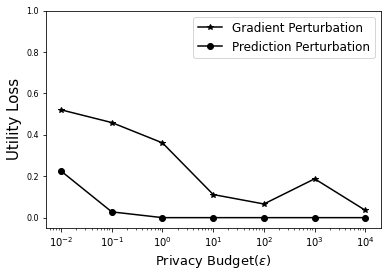

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #grafikleştirme için
import matplotlib.pyplot as plt 
from google.colab import files
test1 = plt.figure()
#plt.semilogx(ep,non_p-acc_obj,color="black",marker='3',label='Objective Perturbation',linewidth=1.5)
plt.semilogx(ep,util_sgd,color="black",marker='*',label='Gradient Perturbation',linewidth=1.5)
#plt.semilogx(ep,np_out-acc_out,color="black",marker='+',linestyle="--",label='Output Perturbation',linewidth=1.5)
plt.semilogx(ep,np_pate-client_acc,color="black",marker='o',label='Prediction Perturbation',linewidth=1.5)
#plt.semilogx(ep,non_p-acc_in,color="orange",marker='.',linestyle="--",label='Input',linewidth=1.5)
#plt.plot(ep,non_p,color="red",marker='*',linestyle="--",label='Non-Private Model',linewidth=2)
plt.legend(loc=1,fontsize=12)
plt.xlabel("Privacy Budget($\epsilon$)",fontsize=13)
plt.ylabel("Utility Loss",fontsize=15)
#plt.xscale('symlog', linthreshy=0.1)
#plt.ylim([-.1,1])
plt.xticks(size = 10)
plt.yticks(size = 8)
plt.ylim([-.05,1])
#y.set_color("black")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['axes.facecolor'] = 'white'
#test1.set_facecolor('white')
test1.show()
test1.savefig('DNN_perturb_acc_loan.pdf')
files.download('DNN_perturb_acc_loan.pdf')

Attack the model

In [ ]:
#Assign necessary variables for attacking the model
import argparse
import csv
import numpy as np
from sklearn.utils import resample, shuffle

import keras
import numpy as np
from sklearn.utils import resample

LEARNING_RATE = 0.001
#EPOCH = 100
EPOCH = 100
DATA_SIZE = 50000
TRAINING_SIZE = 25000
TEST_SIZE = 25000
NUM_TARGET = 1
#NUM_SHADOW = 100
NUM_SHADOW = 10
IN = 1
OUT = 0
VERBOSE = 1

In [ ]:
#call required libraries
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.utils import to_categorical 
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

In [ ]:
#Define model configuaration
# Model configuration
batch_size = 250
#img_width, img_height, img_num_channels = 32, 32, 3
#loss_function = sparse_categorical_crossentropy
no_classes = 7
no_epochs = 250
optimizer = Adam()
validation_split = 0.2
verbosity = 1

In [ ]:
#data sampling
def sample_data(train_data,test_data,num_sets):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    new_x_train, new_y_train = [], []
    new_x_test, new_y_test = [], []
    for i in range(num_sets):
        x_temp, y_temp = resample(x_train, y_train, n_samples=len(y_train), random_state=0)
        new_x_train.append(x_temp)
        new_y_train.append(y_temp)
        x_temp, y_temp = resample(x_test, y_test, n_samples=len(y_test), random_state=0)
        new_x_test.append(x_temp)
        new_y_test.append(y_temp)
    return (new_x_train, new_y_train), (new_x_test, new_y_test)

In [ ]:
def get_trained_keras_models(keras_model, train_data, test_data, num_models):
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    for i in range(num_models):
        models.append(keras.models.clone_model(keras_model))
        models[i].compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
        models[i].fit(x_train[i], y_train[i], batch_size=250, epochs=EPOCH, verbose=VERBOSE, shuffle=True)
        score = models[i].evaluate(x_test[i], y_test[i], verbose=VERBOSE)
        print('\n', 'Model ', i, ' test accuracy:', score[1])
    return models

In [ ]:
#collect the attack dataset from shadow models
def get_attack_dataset(models, train_data, test_data, num_models, data_size):
    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    num_classes = 7#len(y_train[0][0])
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #print(y_idx)
            y_data[y_idx].append(IN)
            print("starts1",j)
        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = np.argmax(y_temp[j])
            p=models[i].predict(x_temp[j:j+1])[0]
            x_data[y_idx].append(p)
            y_data[y_idx].append(OUT)
            print("starts2",j)
    return x_data, y_data

In [ ]:
#collect the attack dataset from target models
def get_target_dataset(models, train_data, test_data, num_models, data_size):
    # generate dataset for the attack model
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    num_classes = 7#len(y_train[0][0])
    x_data, y_data = [[] for i in range(num_classes)], [[] for i in range(num_classes)]
    for i in range(num_models):
        # IN data
        x_temp, y_temp = resample(x_train[i], y_train[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = np.argmax(y_temp[j])
            x_data[y_idx].append(models[i].predict(x_temp[j:j+1])[0])
            #print(y_idx)
            y_data[y_idx].append(IN)
            print("starts1",j)
        # OUT data
        x_temp, y_temp = resample(x_test[i], y_test[i], n_samples=data_size, random_state=0)
        for j in range(data_size):
            y_idx = np.argmax(y_temp[j])
            p=models[i].predict(x_temp[j:j+1])[0]
            x_data[y_idx].append(p)
            y_data[y_idx].append(OUT)
            print("starts2",j)
    return x_data, y_data

In [ ]:
#Get the prediction vectors from the DP model
def get_attack_dataset_combined(x_train, x_test, train_pred, y_train, y_test, test_pred):
    # generate dataset for the attack model
    #(x_train, y_train), (x_test, y_test) = train_data, test_data
    data_size=len(y_train)
    num_class = 7
    x_data, y_data = [[] for _ in range(num_class)], [[] for _ in range(num_class)]
    #for i in range(num_models):
        # IN data
    #x_temp, y_temp = resample(x_train, y_train, n_samples=data_size, random_state=0)
    for j in range(data_size):
            y_idx = np.argmax(y_train[j])
            x_data[y_idx].append(train_pred[j])
            #print(train_pred[j])
            #x_data[y_idx].append(models.predict(x_temp[j:j+1])[0])
            y_data[y_idx].append(IN)
        # OUT data
    #x_temp, y_temp = resample(x_test, y_test, n_samples=data_size, random_state=0)
    for j in range(data_size):
            y_idx = np.argmax(y_test[j])
            #x_data[y_idx].append(models.predict(x_temp[j:j+1])[0])
            x_data[y_idx].append(test_pred[j])
            y_data[y_idx].append(OUT)
    return x_data, y_data

In [ ]:
def build_cnn_model():
    import keras
    from keras.models import Sequential
    from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    num_class=7
    # build the model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(len(x_train[0]),1)))
    model.add(Dense(64, activation='relu'))
    model.add(Flatten())
    #model.add(Dense(50, activation='relu'))
    #model.add(Dense(64, activation='tanh'))
    if num_class==1:
        model.add(Dense(num_class, activation='sigmoid'))    
    else:
        model.add(Dense(num_class, activation='softmax')) 
    model.summary()
    return model

In [ ]:
#generate the report
def get_leakage(models, test_data):
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import average_precision_score
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    (x_test, y_true) = test_data
    acc_scores = []
    pre_scores = []
    rec_scores = []
    fp=np.zeros(len(models))
    tp=np.zeros(len(models))
    tn=np.zeros(len(models))
    fn=np.zeros(len(models))
    for i in range(len(models)):
        y_pred = models[i].predict(x_test[i])
        # _LOG_PRINT(y_pred)
        acc_scores.append(accuracy_score(y_true[i], y_pred))
        pre_scores.append(average_precision_score(y_true[i], y_pred))
        rec_scores.append(recall_score(y_true[i], y_pred))
        tn[i], fp[i], fn[i], tp[i] = confusion_matrix(y_true[i], y_pred).ravel()
    return np.sum(tn),np.sum(tp),np.sum(fn),np.sum(fp)

In [ ]:
#generate the report
def get_lkg(models, test_data):
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import average_precision_score
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    (x_test, y_true) = test_data
    acc_scores = []
    pre_scores = []
    rec_scores = []
    fpr=np.zeros(len(models))
    tpr=np.zeros(len(models))
    #tn=np.zeros(len(models))
    #fn=np.zeros(len(models))
    for i in range(len(models)):
        y_pred = models[i].predict(x_test[i])
        # _LOG_PRINT(y_pred)
        acc_scores.append(accuracy_score(y_true[i], y_pred))
        pre_scores.append(average_precision_score(y_true[i], y_pred))
        rec_scores.append(recall_score(y_true[i], y_pred))
        fpr[i], tpr[i],t = confusion_matrix(y_true[i], y_pred)
    return np.sum(tpr),np.sum(fpr)

In [ ]:
n=25000
shadow_train = (x_train[n:n*2],y_train[n:n*2])
shadow_test = (x_test[n:n*2],y_test[n:n*2])
shadow_train_data, shadow_test_data = sample_data(shadow_train, shadow_test, NUM_SHADOW)

In [ ]:
cnn_model=build_cnn_model()
# compile the shadow models
shadow_models = get_trained_keras_models(cnn_model, shadow_train_data, shadow_test_data, NUM_SHADOW)

In [ ]:
attack_train = get_attack_dataset(shadow_models, shadow_train_data, shadow_test_data, NUM_SHADOW, TEST_SIZE)
#attack_train=get_attack_data(shadow_models,shadow_train_data,shadow_test_data,5)

In [ ]:
#calculate attack accuracy against non-private model
#ob_model=obj_model(1000)
xtrain_agg=x_train[0:n]
ytrain_agg=y_train[0:n]
#ytrain_agg=ytrain_agg.to_numpy()
#ytrain_pred=model_np.predict_proba(xtrain_agg)
xtest_agg=x_test[0:n]
ytest_agg=y_test[0:n]
#ytest_agg=ytest_agg.to_numpy()
#ytest_pred=model_np.predict_proba(xtest_agg)
target_train_agg = (xtrain_agg,ytrain_agg)
target_test_agg = (xtest_agg,ytest_agg)
target_train_data, target_test_data = sample_data(target_train_agg, target_test_agg, NUM_TARGET)

In [ ]:
#non-private model
target_model = get_trained_keras_models(cnn_model, target_train_data, target_test_data, 1)
attack_test = get_attack_dataset(target_model, target_train_data, target_test_data, 1, TEST_SIZE)

In [ ]:
#calculate the prediction
from sklearn.metrics import accuracy_score
ypred=target_model[0].predict_classes(xtrain_agg)
accuracy_score(label(ytrain_agg), ypred)
#print(eps)

In [ ]:
##attack classifier:RF
def get_trained_RF_models(train_data, test_data, num_models):
    from sklearn.ensemble import RandomForestClassifier
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    score=np.zeros(num_models)
    #RF=RandomForestClassifier(random_state=0)
    for i in range(num_models):
        print('Training RF model : ', i)
        models.append(RandomForestClassifier(random_state=0))
        models[i].fit(x_train[i], y_train[i])
        score[i] = models[i].score(x_test[i],y_test[i])
        print('Random Forest model ', i, 'score : ',score)
    return models, score

In [ ]:
def get_trained_svm_models(train_data, test_data, num_models):
    from sklearn import svm
    (x_train, y_train), (x_test, y_test) = train_data, test_data
    models = []
    k=0
    for i in range(num_models):
        print('Training svm model : ', i)
        models.append(svm.SVC(gamma='scale',kernel='linear',verbose=VERBOSE))
        models[i].fit(x_train[i], y_train[i])
        score = models[i].score(x_test[i],y_test[i])
        print('SVM model ', i, 'score : ',score)
        k=k+1
        print('this is executable',k)
    return models,score

In [ ]:
#generate the report #svm model
def get_score_svm_models(models, test_data):
    from sklearn.metrics import accuracy_score, precision_score, recall_score
    from sklearn.metrics import average_precision_score
    (x_test, y_true) = test_data
    acc_scores = []
    pre_scores = []
    rec_scores = []
    for i in range(len(models)):
        y_pred = models[i].predict(x_test[i])
        # _LOG_PRINT(y_pred)
        acc_scores.append(accuracy_score(y_true[i], y_pred))
        pre_scores.append(average_precision_score(y_true[i], y_pred))
        rec_scores.append(recall_score(y_true[i], y_pred))
    return np.average(acc_scores)

In [ ]:
attack_model,scores = get_trained_svm_models(attack_train,attack_test, 7)

In [ ]:
def calc_labelAcc(Model,xtest,ytest):
  from sklearn.metrics import accuracy_score
  ypred=Model.predict_classes(xtest)
  acc=accuracy_score(label(ytest), ypred)
  return acc

In [ ]:
def lk(tn,tp,fn,fp):
  tpr=(tp/(tp+fn))
  fpr=(fp/(fp+tn))
  return tpr-fpr

In [ ]:
#privacy leakage non-private model
tn1,tp1,fn1,fp1=get_leakage(attack_model, attack_test)
lk(tn1,tp1,fn1,fp1)

0.028240000000000043

Test on DP-SGD models

Calculate attack accuracy/Leakage

In [ ]:
p=len(ep)
lgd=np.zeros(p)
tn2=np.zeros(p)
tp2=np.zeros(p)
fn2=np.zeros(p)
fp2=np.zeros(p)
for i in range(len(ep)):
     target_model=[]
     modelSGD=globals()['model_sgd%s' % i]
     target_model.append(modelSGD)
     attack_test_agg=get_attack_dataset(target_model, target_train_data, target_test_data, 1, TEST_SIZE)
     tn2[i],tp2[i],fn2[i],fp2[i]=get_leakage(attack_model, attack_test_agg)
     lgd[i]=lk(tn2[i],tp2[i],fn2[i],fp2[i])

In [ ]:
#calc_labelAcc(model_c0,xtest_agg,ytest_agg)*100

In [ ]:
print(lgd)
print(tp2)

[ 0.0022   0.00204 -0.00064  0.00692  0.00412 -0.0088   0.00164]
[10961.  8011.  9596. 11952. 12071.  9034. 12584.]


[ 0.0022   0.00204 -0.00064  0.00692  0.00412 -0.0088   0.00164]
[10961.  8011.  9596. 11952. 12071.  9034. 12584.]

PATE

In [ ]:
def PATE(ep,xtest1,ytest1):
            sum_t=np.zeros([len(ytest1),7])
            for k1 in range(100):
               sum=PATE_sum(xtest1,ytest1)
               sum_s=np.zeros(sum.shape)
               sum_n=sum
               sum_s=sum_n+np.random.laplace(loc=0.0, scale=1/ep)
               sum_t=sum_s+sum_t

            return sum_t/100
          


In [ ]:
def PATE_sum(xtest1,ytest1):
  sum=np.zeros([len(ytest1),7])
  for iter in range(M):
    New_model=globals()['model_pate%s' % iter]
    y=np.zeros([len(ytest1),7])
    y=New_model.predict_proba(xtest1)
  #print(y.shape)
    y=vote(y)
    sum=y+sum
  return sum

In [ ]:
p=len(ep)
lpate=np.zeros(p)
tn4=np.zeros(p)
tp4=np.zeros(p)
fn4=np.zeros(p)
fp4=np.zeros(p)
for i in range(len(ep)):
     ytrain_pred=PATE(ep[i],xtrain_agg,ytrain_agg)
     ytest_pred=PATE(ep[i],xtest_agg,ytest_agg)
     attack_test_agg=get_attack_dataset_combined(xtrain_agg,xtest_agg,ytrain_pred,ytrain_agg,ytest_agg,ytest_pred)
     print("complete")
     tn4[i],tp4[i],fn4[i],fp4[i]=get_leakage(attack_model, attack_test_agg)
     lpate[i]=lk(tn4[i],tp4[i],fn4[i],fp4[i])

In [ ]:
print(lpate)
print(tp4)


[0.      0.00028 0.00028 0.00028 0.00028 0.00028 0.00028]
[10000. 14733. 14733. 14733. 14733. 14733. 14733.]

plot the graph

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

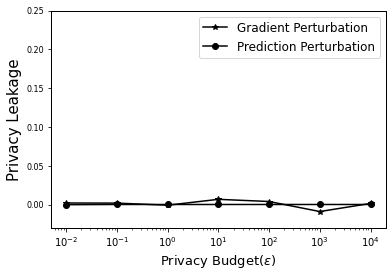

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #grafikleştirme için
import matplotlib.pyplot as plt 
from google.colab import files
test1 = plt.figure()
#plt.semilogx(ep,lobj,color="black",marker='3',label='Objective Perturbation',linewidth=1.5)
plt.semilogx(ep,lgd,color="black",marker='*',label='Gradient Perturbation',linewidth=1.5)
#plt.semilogx(ep,lout,color="black",marker='+',linestyle="--",label='Output Perturbation',linewidth=1.5)
plt.semilogx(ep,lpate,color="black",marker='o',label='Prediction Perturbation',linewidth=1.5)
#plt.semilogx(ep,non_p-acc_in,color="orange",marker='.',linestyle="--",label='Input',linewidth=1.5)
#plt.plot(ep,non_p,color="red",marker='*',linestyle="--",label='Non-Private Model',linewidth=2)
plt.legend(loc=1,fontsize=12)
plt.xlabel("Privacy Budget($\epsilon$)",fontsize=13)
plt.ylabel("Privacy Leakage",fontsize=15)
#plt.xscale('symlog', linthreshy=0.1)
#plt.ylim([-.1,1])
plt.xticks(size = 10)
plt.yticks(size = 8)
plt.ylim([-.03,.25])
#y.set_color("black")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['axes.facecolor'] = 'white'
#test1.set_facecolor('white')
test1.show()
test1.savefig('DNN_perturb_leakage_loan.pdf')
files.download('DNN_perturb_leakage_loan.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

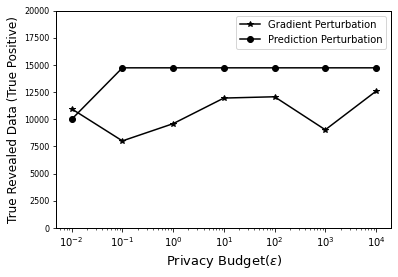

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #grafikleştirme için
import matplotlib.pyplot as plt 
from google.colab import files
test1 = plt.figure()
#plt.semilogx(ep,tp1,color="black",marker='D',label='Objective Perturbation',linewidth=1.5)
plt.semilogx(ep,tp2,color="black",marker='*',label='Gradient Perturbation',linewidth=1.5)
#plt.semilogx(ep,tp3,color="black",marker='<',label='Output Perturbation',linewidth=1.5)
plt.semilogx(ep,tp4,color="black",marker='o',label='Prediction Perturbation',linewidth=1.5)
#plt.semilogx(ep,non_p-acc_in,color="orange",marker='.',linestyle="--",label='Input',linewidth=1.5)
#plt.plot(ep,non_p,color="red",marker='*',linestyle="--",label='Non-Private Model',linewidth=2)
plt.legend(loc=1,fontsize=10)
plt.xlabel("Privacy Budget($\epsilon$)",fontsize=13)
plt.ylabel("True Revealed Data (True Positive)",fontsize=12)
#plt.xscale('symlog', linthreshy=0.1)
#plt.ylim([-.1,1])
plt.xticks(size = 10)
plt.yticks(size = 8)
plt.ylim([0,20000])
#y.set_color("black")
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams['axes.facecolor'] = 'white'
#test1.set_facecolor('white')
test1.show()
test1.savefig('DNN_perturb_tp_loan.pdf')
files.download('DNN_perturb_tp_loan.pdf')